6. Напишите функцию stochastic_gradient_descent, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:

•features - матрица, соответствующая обучающей выборке

•w_init - вектор начальных весов модели

•eta - шаг градиентного спуска (по умолчанию 0.001)

•max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)

•max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска, при котором алгоритм прекращает работу (по умолчанию 1e-8)

•seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)

•verbose - флаг печати информации (например, для отладки, по умолчанию False)

На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки.

Функция должна возвращать вектор весов w, а также вектор (список) ошибок, число итераций


In [1]:
import numpy as np
import pandas as pd
from time import time

from thbmodel.utils import timestamp, YEAR, MONTH,settings
from thbmodel.utils.arrayview import ArrayView, TimeseriesView

from thbmodel.prediction.models.fit_model import TSModel
from thbmodel.prediction.models.model_parameters import ModelParameters
from thbmodel.prediction.models.factor_management import FactorList
from thbmodel.prediction.models.preprocessing import load_slices

from thbmodel.prediction.models.prediction import factornames_trimmed
from thbmodel.prediction.models.parameters import factor_build_end

In [2]:
def softmax(x, axis =1):

    v_exp = np.exp(x)
    sf = np.divide(v_exp, np.nansum(v_exp, axis =axis).reshape(-1,1))
    mask = np.isnan(sf)
    if mask.any():
        return np.where(mask, 1, sf)
    return sf

In [92]:
def G_step(df_t, winner, t_len, w, verbose=False):
    """ 
    Gradient step 
    return gradient 
    
    df <= [n,i,j] 3d tensor of datas (n) event, (i) -horse, (j) factor
    winner <=  [n,i] 2d tensor (matrix) (n) event, (i) -horse, value 1 if won event else 0
    t_len <= [n] 1d tensor (vector) (n) event, value number of horses in event
    w <=  Model's parameters
    verbose <=  flaf debaging
    """
    b_size,h,f = df_t.shape
    
    S = np.einsum('nij, j -> ni', df_t,w)
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S) 
    delta = winner - p
    
    grad_w = np.zeros_like(w)
    x = np.where(np.isnan(df_t), 0, df_t)
    grad_w = np.einsum('ni, nij -> j', delta, x)
      
    if verbose:
        print 'shape grad_w ',grad_w.shape
        print 'grad_w  ',grad_w[:10]
            
    
    return -np.divide(grad_w, b_size)

In [4]:
def DF_to_tensor(df, features, max_horses =60):
    """
    turn DataFrame to Tensor 
    where each event is in one matrix 
    """
    

    length = df.event_id.unique().__len__()
    f = len(features)
    t_Horses_factors = np.full((length, max_horses, f), np.nan)
    t_winner = np.zeros((length, max_horses))
    t_length = np.zeros(length)
    for  n, (_,df_sub) in enumerate(df.groupby(df['event_id'])):
        h = df_sub.loc[:,features].values.shape[0]
        t_Horses_factors[n, :h,:] = df_sub.loc[:,features].values
        t_winner[n, :h] = (df_sub['result'] ==1).values.astype(int)
        t_length[n] = h
    
    return t_Horses_factors, t_winner, t_length

In [5]:
av = ArrayView.from_file(settings.paths.join('racing_data_azd.av.bcolz'))
tsav = load_slices()

In [6]:
build_end =float(timestamp('2016-04-01'))
oos_start =float(timestamp('2017-05-01'))
pars = ModelParameters(av, build_end =build_end, oos_start =oos_start, depth=1, lmbd=10, verbose=False)

In [7]:
fl = FactorList.from_av(av, factornames_trimmed)
fl.preprocess(pars)
factors = fl.asmatrix()
print 'is1_start  ',(timestamp(av.start_time[pars.is1][0]))
print 'is1_end  ',(timestamp(av.start_time[pars.is1][-1]))
print 'oos_start  ',(timestamp(av.start_time[pars.oos][0]))
print 'oos_end  ',(timestamp(av.start_time[pars.oos][-1]))

is1_start   2016-04-01 12:40:00.000000
is1_end   2017-04-30 16:45:00.000000
oos_start   2017-05-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000


In [8]:
# создаем дата фрейм из данных 
def DF(mask, factors, av, factors_names, other_names):
    
    import pandas as pd
    
    df = pd.DataFrame(data =factors[:, mask].T , columns = factors_names)
    for col in other_names :
        
        df[col] = av[col][mask]
        
    return df

In [9]:
import pandas as pd
pd.set_option('display.max_columns', 90)
n,m = factors.shape
col_names = ['f{}'.format(i) for i in range(1,n+1)]

df = DF (pars.model_mask, factors, av, col_names, ['event_id', 'result'])
df['is1'] = pars.is1 [pars.model_mask]
df['is2'] = pars.is2 [pars.model_mask]
df['oos'] = pars.oos [pars.model_mask]


df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,event_id,result,is1,is2,oos
0,0.367198,-2.822814,1.042788,-1.449000,-0.399689,1.519560,1.120796,-0.903438,2.149808,0.454737,0.397418,2.018940,-0.041120,-1.864951,0.903440,-0.595091,-2.351100,0.791641,-0.371619,-0.134965,0.383271,-1.827844,-0.662651,1.423997,0.518412,0.633018,-0.217998,-0.046744,1.832861,0.362147,1.789398,0.713323,0.847637,2.197710,0.333612,0.992382,2.005222,1.745112,-2.169849,0.024419,0.516602,0.838355,-0.231825,0.510499,-0.818574,1.690850,1.153778,0.0,-0.178424,1.606775,1.276101,0.903439,-0.903432,1.539463,307976,4,True,True,False
1,0.367198,-2.822814,1.146508,-0.950907,0.134657,1.279091,0.709838,0.511180,1.163663,0.554670,0.589283,2.676868,-0.853920,-1.762160,-0.511180,0.355150,0.325790,-0.024739,0.462871,0.297558,1.503070,-1.925740,-0.642401,2.296713,-0.518494,1.678214,-0.325527,0.081803,-0.721549,3.691803,1.126171,1.576948,0.329637,0.138260,1.866920,1.105528,1.685527,1.745112,-1.926777,0.024419,-0.399449,0.838355,1.043211,0.510499,-0.881552,0.215314,0.760771,0.0,-0.103089,1.421764,0.382060,-0.511180,0.511188,-0.341251,307976,1,True,True,False
2,0.367198,-2.269686,1.109573,1.041469,-1.246235,0.959507,0.533713,-0.834292,2.054531,0.589805,0.781147,-0.425354,-0.308430,-1.495752,0.834292,-0.561211,0.570014,-1.385371,0.230456,0.295614,0.221700,-1.316387,-1.368199,0.486579,1.954420,0.373406,-0.280811,0.210350,0.824291,0.099820,0.924145,0.695130,0.329637,-2.094361,0.463911,1.114437,1.611524,1.745112,-1.271665,-0.100011,-0.118486,-1.065489,-0.231825,0.510499,2.544475,-0.108367,-0.777575,0.0,-0.034824,0.366740,0.442908,0.834292,-0.834286,0.687687,307976,2,True,True,False
3,0.367198,-2.082636,-0.546706,1.041469,-0.177928,0.807879,1.825297,0.377624,-0.891473,2.359050,0.690858,-1.025506,2.586447,-1.542717,-0.377623,0.483454,0.439499,-1.929624,-0.011781,0.218581,1.028220,-0.193052,-0.390140,-0.525911,0.543346,0.061765,-0.134161,0.210350,-1.481083,-1.201241,-0.343101,-0.052652,-0.188364,0.024540,-0.598031,-0.847758,1.648525,1.745112,-0.854125,-0.057719,-0.967518,-1.950998,-0.231825,0.510499,-0.705213,-0.063721,0.946241,0.0,0.028652,0.979326,3.985849,-0.377623,0.377629,1.750346,307976,5,True,True,False
4,0.367198,-1.620791,0.904502,1.041469,-0.645139,0.037615,-0.229496,-0.471971,1.330716,1.717160,0.167181,-0.232777,-0.308430,-0.513871,0.471972,-0.296116,0.195127,-1.385371,0.358433,0.311468,1.782793,-1.105682,-0.162607,-0.525911,1.667236,1.301977,-0.517036,0.210350,0.340718,4.356093,0.522335,1.517120,-0.188364,-1.785856,1.200810,0.854792,0.270584,1.745112,-0.640691,0.049978,-0.749274,-0.453683,-0.231825,0.510499,2.587987,-0.043631,1.434019,0.0,-0.145211,1.003482,0.699005,0.471972,-0.471966,0.365180,307976,8,True,True,False


In [10]:
def LL_f (df_t, winner, w):
    
    S = np.einsum('nij, j -> ni', df_t,w) 
    S = np.where(np.isnan(S), -np.inf, S)
    p = softmax(S)  
    LL = np.log(np.einsum('ni, ni -> n', p, winner)).mean()
    
    return LL

In [11]:
import time
start = time.time()
df_train_t, winner_tr_t, t_len_tr = DF_to_tensor(df.loc[df.is1.values,:], col_names)
df_test_t, winner_ts_t, t_len_ts = DF_to_tensor(df.loc[df.oos.values,:], col_names)
end = time.time()
print 'DataFrame to tensors {}'.format(end -start)

DataFrame to tensors 25.0801830292


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
def AdaMax_iter_time(data, features,  w = None, b_size =100, eta=1e-3, 
                                moment1 = 0.85, moment2 = 0.99, la = 10., N_epoh =10, direction =False,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск 
    при каждой итерации проходим все скачки от новых к старым c размером b_size один раз
    переходим на следущую итерацию и повторяем проход по скачкам
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  начальное приближение для параметров модели
    b_size  <=  размер бача
    eta <=  шаг обучения
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    direction <= True if forward False if back
    eps <=  почти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """
    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
         w = np.random.normal(0, scale =1e-2, size =(len(features)))
    
    # Step
    iter_num = 0
    
    # last gradient value
    last_grad = np.zeros_like(w) 
    # last gradient's variation value
    std_grad = np.zeros_like(w)
    # unique events in data set
    events_list = np.unique(data['event_id'])
    step_max = len (events_list)/b_size
    # store of grad changes
    grad_norm = np.zeros(N_epoh *step_max +1)
    # Main loop
    for  i_ep  in range(1, N_epoh+1):
                
        for step_ in range(1, step_max +1):
            
            if direction:
                r_event = events_list[b_size*(step_): b_size*(step_+1)]
            else:
                r_event = events_list[-b_size*(step_ +1): -b_size*step_]
            df = data.loc[np.in1d(data['event_id'], r_event),:]
            
            df_t, winner_t, t_len = DF_to_tensor(df, features)
            
            w_N = w - eta *moment1 *last_grad # for Nesterov momentum
            # get gradient with  Nesterov momemtum + L2 regularisation
            grad_ = G_step(df_t, winner_t, t_len, w_N, verbose=False) + la * w_N  # gradient and L2
            #grad_ = G_step(df_t, winner_t, t_len, w, verbose=False) + la * w  # gradient and L2
            last_grad = moment1 * last_grad + (1-moment1) * grad_ # Update weight first moment estimate
            # Update weight second moment estimate exponent power infinity
            std_grad = np.max(np.vstack((moment2 * std_grad, np.abs(grad_))), axis =0) # Update weight second moment estimate 
            
            t = (i_ep -1)*step_max + step_
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
        
            w = w - eta *last_grad_/std_grad
        
            weight_dist = np.linalg.norm(last_grad, ord=2)/len(w)
            grad_norm [t] = weight_dist
            
            if (weight_dist <= min_weight_dist):
                print 'SGD covergence', t
                break
                return w, grad_norm , iter_num*step_
        
            if verbose:
                #print 'w  ', w
                print 'iteration', iter_num, 'dist ',weight_dist
         
            if np.any((w == np.inf ) |(w == -np.inf)):
                print "w overcome"
                break
        
    return w, grad_norm , t

In [89]:
def AdaMax_time_step(data, features,  w = None, b_size =100, eta=1e-3, 
                                moment1 = 0.85, moment2 = 0.99, la = 10., max_iter =10,
                                eps = 1e-4,  min_weight_dist=1e-3, seed=42, verbose=False):
    """ 
    градиентный спуск 
    берем b_size скачек более новых и делаем с ними max_iter итераций 
    затем следующие b_size скачек старее и делаем с ними max_iter итераций
    пока на переберем все скачки
    
    data <= табдица с данными содержащая len(features)-столбцов данных, столбец с номерами - event_id, 
            столбец с результатом - result
    features <=  наименование признаков в данных 
    w <=  начальное приближение для параметров модели
    b_size  <=  размер бача
    eta <=  шаг обучения
    moment1 <=  первый момент
    moment2 <=  второй момент
    la <=  коффициент регуляризации
    max_iter <=  максимальное число итераций
    eps <=  почти ноль  
    min_weight_dist <=  признак сходимости параметров 
    seed <=  рандомная константа 
    verbose <=  флаг отладки
    """

    
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    #np.random.seed(seed)
    if w == None:
        w = np.random.normal(0, scale =1e-2, size =(len(features)))
    
    # Step
    step_ = 0
    
    # last gradient value
    last_grad = np.zeros_like(w) 
    # last gradient's variation value
    std_grad = np.zeros_like(w)
    # unique events in data set
    events_list = np.unique(data['event_id'])
    step_max = len (events_list)/b_size
    # store of grad changes
    grad_norm = np.zeros(max_iter *step_max +1)
    # Main loop
    for step_ in range (1, step_max +1):
        
        r_event = events_list[-b_size*(step_ +1): -b_size*step_]
        df = data.loc[np.in1d(data['event_id'], r_event),:]
        
        df_t, winner_t, t_len = DF_to_tensor(df, features)
        for iter_num  in range(1, max_iter +1):
            
            w_N = w - eta *moment1 *last_grad # for Nesterov momentum
            # get gradient with  Nesterov momemtum + L2 regularisation
            grad_ = G_step(df_t, winner_t, t_len, w_N, verbose=False) + la * w_N  # gradient and L2 
            #grad_ = G_step(df_t, winner_t, t_len, w, verbose=False) + la * w  # gradient and L2 
            last_grad = moment1 * last_grad + (1-moment1) * grad_ # Update weight first moment estimate
            # Update weight second moment estimate expanent power infinity
            std_grad = np.max(np.vstack((moment2 * std_grad, np.abs(grad_))), axis =0) # Update weight second moment estimate 
        
            t = max_iter *(step_-1) + iter_num
            last_grad_ = last_grad/(1 - np.power(moment1, t)) # Correct first moment estimate
        
            w = w - eta *last_grad_/std_grad
        
            weight_dist = np.linalg.norm(last_grad, ord=2)/len(w)
            grad_norm [t]   = weight_dist
            
        if (weight_dist <= min_weight_dist):
            print 'SGD covergence', t
            break
            return w, grad_norm , iter_num*step_
        
        if verbose:
            #print 'w  ', w
            print 'iteration', iter_num, 'dist ',weight_dist
        
        if np.any(w == np.nan):
            print "w overcome"
            break
        
    return w, grad_norm , t

In [14]:
events_list = np.unique(df.loc[df.is1.values,'event_id'])
print 'steps  ', len(events_list)/100

steps   138


In [80]:
import time
start = time.time()

SGD3_b = AdaMax_iter_time(df.loc[df.is1.values,:], col_names, b_size =100, eta = 1e-3, moment1 = 0.97, \
                                         moment2 =0.999,  la = 3, N_epoh =10, verbose=False)

end = time.time()
print 'Time taken to stohastic gradient {}'.format(end - start)

SGD covergence 1
Time taken to stohastic gradient 189.272979975


In [99]:
import time
start = time.time()

SGD3_f = AdaMax_iter_time(df.loc[df.is1.values,:], col_names, b_size =100, eta = 1e-3, moment1 = 0.97, \
                                         moment2 =0.99,  la = 3, N_epoh =10, direction =True, verbose=False)

end = time.time()
print 'Time taken to stohastic gradient {}'.format(end - start)

SGD covergence 1
Time taken to stohastic gradient 189.271154165


In [33]:
events_list = np.unique(df.loc[df.is1.values,'event_id'])
print 'steps  ', len(events_list)/1000

steps   13


In [93]:
import time
start = time.time()

SGD4 = AdaMax_time_step(df.loc[df.is1.values,:], col_names, b_size =1000, eta = 1e-3, moment1 = 0.97, \
                                         moment2 =0.99,  la = 3, max_iter =100, verbose=False)

end = time.time()
print 'Time taken to stohastic gradient {}'.format(end - start)

SGD covergence 200
Time taken to stohastic gradient 4.95324110985


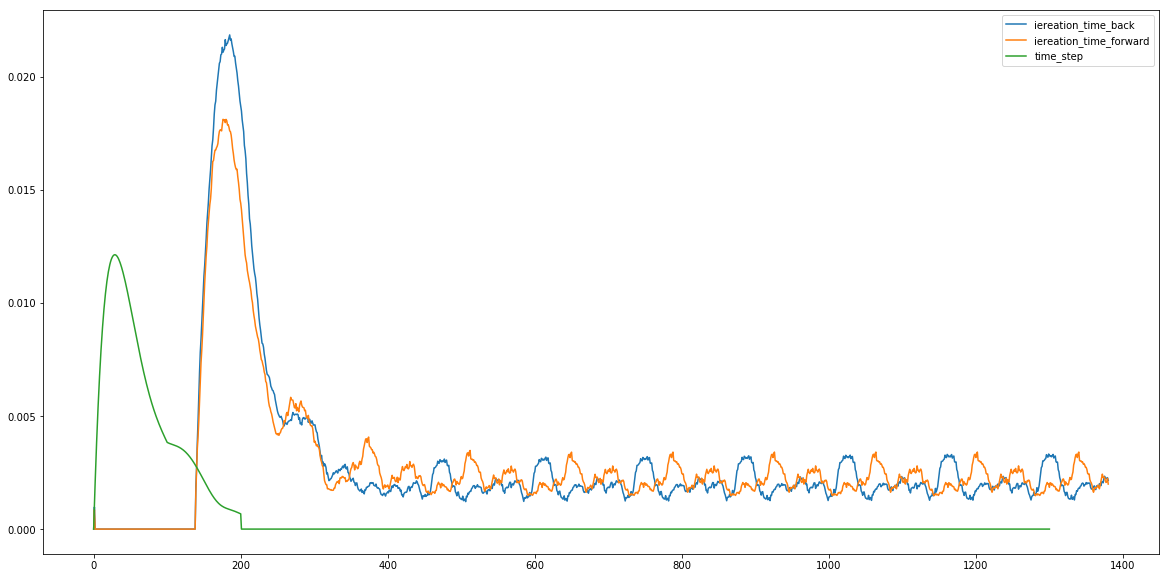

0.0021720573149
0.00218593994445
0.000673650366468


In [94]:
plt.figure(figsize=(20, 10))
plt.plot(SGD3_b[1], label ='iereation_time_back')
plt.plot(SGD3_f[1], label ='iereation_time_forward')
plt.plot(SGD4[1], label ='time_step')
plt.legend()
plt.show()
print SGD3_b[1][SGD3[1]> 0][-1]
print SGD3_f[1][SGD3[1]> 0][-1]
print SGD4[1][SGD4[1]> 0][-1]

In [82]:
w0 = SGD3_f[0] # return to original shape
start = time.time()
likelihood = LL_f (df_train_t, winner_tr_t, w0)
end = time.time()
print 'count ll for train data {} by Adam_iter_time'.format(end -start)
print likelihood

count ll for train data 0.0404031276703 by Adam_iter_time
-1.98821083812


In [83]:
w0 = SGD3_b[0] # return to original shape
start = time.time()
likelihood = LL_f (df_train_t, winner_tr_t, w0)
end = time.time()
print 'count ll for train data {} by Adam_iter_time'.format(end -start)
print likelihood

count ll for train data 0.0460569858551 by Adam_iter_time
-1.9961506347


In [84]:
w0 = SGD4[0] # return to original shape
start = time.time()
likelihood = LL_f (df_train_t, winner_tr_t, w0)
end = time.time()
print 'count ll for train data {} by Adam_time_step'.format(end -start)
print likelihood

count ll for train data 0.0498261451721 by Adam_time_step
-1.99495426658


In [85]:
w0 = SGD3_f[0] # return to original shape
start = time.time()
likelihood = LL_f (df_test_t, winner_ts_t, w0)
end = time.time()
print 'count ll for test data {} by Adam_iter_time'.format(end -start)
print likelihood

count ll for test data 0.0139899253845 by Adam_iter_time
-1.99849806695


In [86]:
w0 = SGD3_b[0] # return to original shape
start = time.time()
likelihood = LL_f (df_test_t, winner_ts_t, w0)
end = time.time()
print 'count ll for test data {} by Adam_iter_time'.format(end -start)
print likelihood

count ll for test data 0.0290970802307 by Adam_iter_time
-2.00551363843


In [87]:
w0 = SGD4[0] # return to original shape
start = time.time()
likelihood = LL_f (df_test_t, winner_ts_t, w0)
end = time.time()
print 'count ll for test data {} by Adam_time_step'.format(end -start)
print likelihood

count ll for test data 0.0274538993835 by Adam_time_step
-2.00409685347


In [36]:
for i in range(10):
    
    W1 = np.random.normal(loc =w0, scale =1e-2, size =(len(col_names)))
    print 'train  ',LL_f (df_train_t, winner_tr_t, W1)
    print 'test  ',LL_f (df_test_t, winner_ts_t, W1)

train   -2.02427213499
test   -2.02850240438
train   -2.01594138785
test   -2.02236116846
train   -2.02133836841
test   -2.02840198534
train   -2.04109180742
test   -2.04337431746
train   -2.02385636721
test   -2.03031722461
train   -2.0261073981
test   -2.03530076029
train   -2.03223450265
test   -2.03733933133
train   -2.02455212414
test   -2.03231205185
train   -2.01761160293
test   -2.02539962818
train   -2.0218015718
test   -2.02765410657
